<a href="https://colab.research.google.com/github/Eunoianivi123/ML_Tensorflow/blob/main/PreTrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary modules

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras

In [9]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar() # disable the progress of downloading the data and preparing the data.

(raw_train,raw_validation,raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split = ['train[:80]', 'train[80:90]', 'train[90:]'],
    with_info = True, # provides additional metadate about the data
    as_supervised = True, # the data is returned as (image, label) pairs.
)

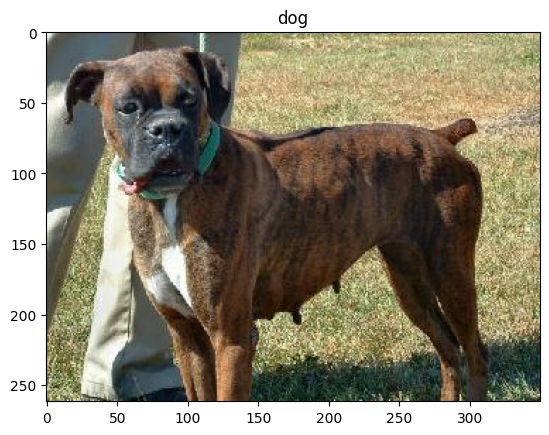

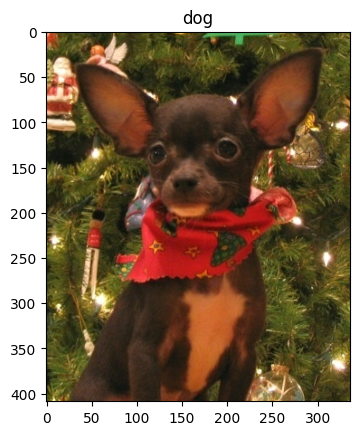

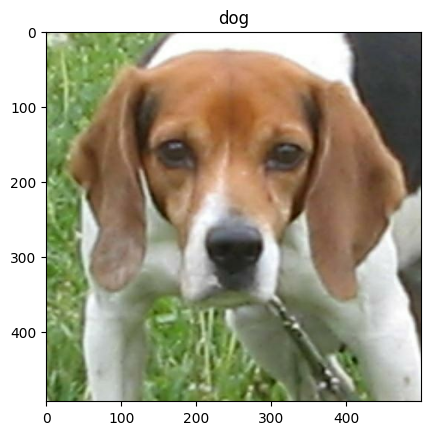

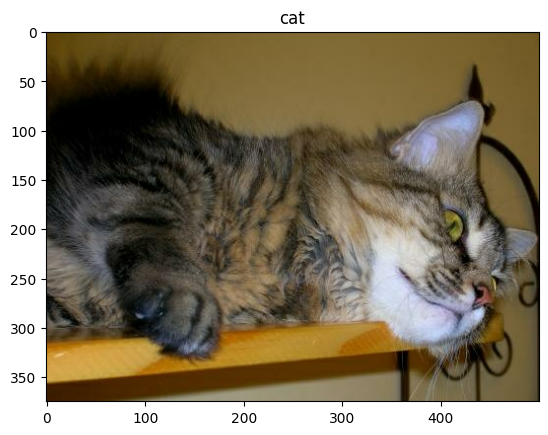

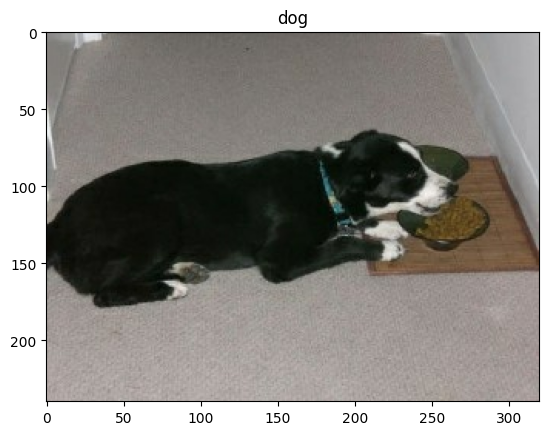

In [10]:
get_label_name = metadata.features['label'].int2str

for image,label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [71]:
#making all the images to the same size

img_size = 160

def format_example(image, label):# creating a function to resize the image
  image = tf.cast(image, tf.float32) # convert the datatype of "image" to "32-bit floating point"(ususally happens during preprocessing)
  image = (image/ 127.5) - 1 # convert the range [0,255] to [-1,1]
  image = tf.image.adjust_brightness(image, delta= 0.5)
  image = tf.image.adjust_contrast(image, contrast_factor = 1 )
  image = tf.image.adjust_saturation(image, saturation_factor = 1)
  image = tf.image.adjust_hue(image, delta = 10 )
  image = tf.image. resize(image, (img_size, img_size)) # resize the image to 160*160 pixels.
  return image,label

In [72]:
# changing the img size of all the imgs using .map()

train = raw_train.map(format_example)
validation= raw_validation.map(format_example)
test = raw_test.map(format_example)

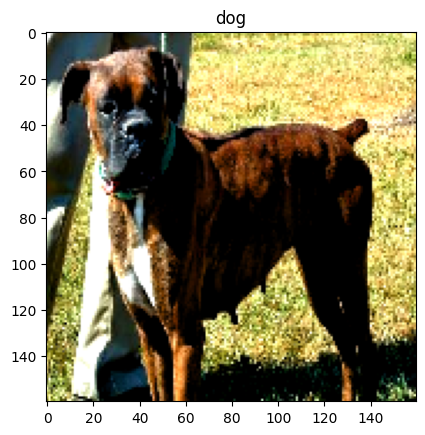

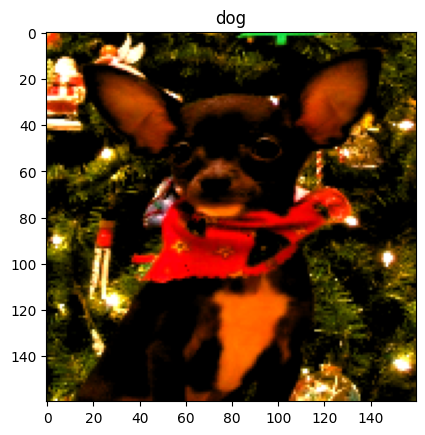

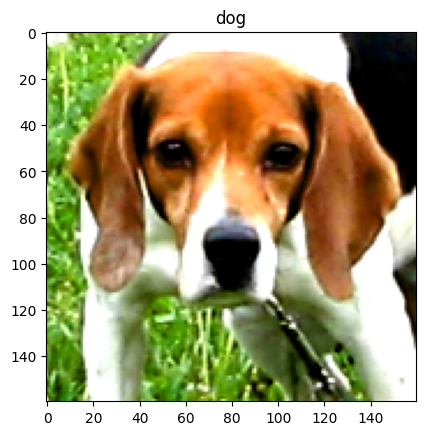

In [73]:

for image,label in train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [74]:
batch_size = 32
shuffle_buffer_size = 1000

train_batches = train.shuffle(shuffle_buffer_size).batch(batch_size)
validation_batches = validation.batch(batch_size)
test_batches = test.batch(batch_size)

Original Image: (262, 350, 3)
New shape: (160, 160, 3)


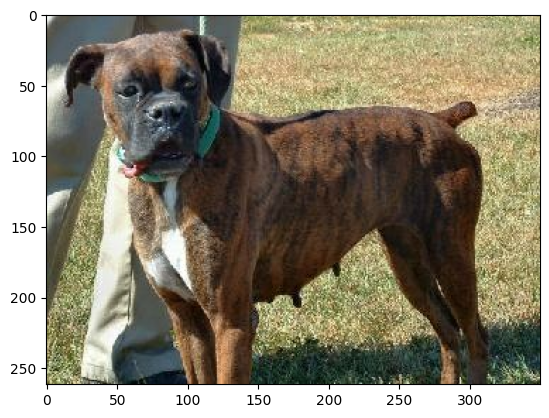

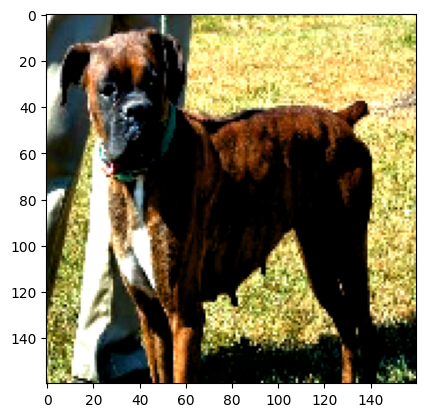

In [76]:
for image,label in raw_train.take(1):
  print("Original Image:", image.shape)
  plt.figure()
  plt.imshow(image)

for image,label in train.take(1):
  print("New shape:", image.shape)
  plt.figure()
  plt.imshow(image)

In [77]:
#using a pretrained model
#MobileNetV2 is the model pre-trained by google(1.4M images, 1000 classification) and we are including only the base convolutional layer of it.

img_shape = (img_size,img_size, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape = img_shape, include_top = False, weights = 'imagenet' )

9406464/9406464 [==============================] - 0s 0us/step


In [78]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [80]:
for image,_ in train_batches.take(1): pass

feature_batch = base_model(image) # here 32 mean the number of filters. print(feature_batch.shape)

In [81]:
#freezing refers to disabling the training property(won't make any changes to the weights od any layers in base_model).

base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [83]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(1)

In [84]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [86]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [87]:
initial_epochs = 3
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 1/20 [>.............................] - ETA: 37s - loss: 0.6290 - accuracy: 0.6000

20/20 [==============================] - 2s 5ms/step - loss: 0.6290 - accuracy: 0.6000


In [88]:
history = model.fit(
    train_batches,
    epochs = initial_epochs,
    validation_data = validation_batches
)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
3/3 [==============================] - 5s 543ms/step - loss: 0.7028 - accuracy: 0.5625 - val_loss: 0.3813 - val_accuracy: 0.9000
Epoch 2/3
3/3 [==============================] - 3s 796ms/step - loss: 0.4075 - accuracy: 0.7750 - val_loss: 0.3023 - val_accuracy: 0.9000
Epoch 3/3
3/3 [==============================] - 2s 525ms/step - loss: 0.3041 - accuracy: 0.8750 - val_loss: 0.2793 - val_accuracy: 0.9000
[0.5625, 0.7749999761581421, 0.875]


In [90]:
model.save("cats_vs_dogs.h5")
new_model = tf.keras.models.load_model('cats_vs_dogs.h5')